# Multilayer Perceptron <br>

In this notebook, we will create three simple multilayer perceptrons (MLP) neural network to classify the handwritten numbers from the MNIST.<br>
Enjoy!

## Import and preparing data

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import copy
import random
import time

**Useful functions**

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


**Downloading the data**

In [16]:
ROOT = '.data'

ds = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

**Normalizing data and creating the datasets and iterators**

In [17]:
mean = ds.data.float().mean() / 255
std = ds.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [18]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [19]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## Networks creation <br>

Here we make three different models, with one, two and three hidden layers

In [20]:
class MLP_one(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_layer = nn.Linear(input_dim, 250)
        self.h1 = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.h1(x))
        x = self.output_layer(x)
        return x

class MLP_two(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_layer = nn.Linear(input_dim, 250)
        self.h1 = nn.Linear(250, 450)
        self.d1 = nn.Dropout(0.4)
        self.h2 = nn.Linear(450,100)
        self.output_layer = nn.Linear(100, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.h1(x))
        x = self.d1(x)
        x = F.relu(self.h2(x))
        x = self.output_layer(x)
        return x
    
class MLP_three(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_layer = nn.Linear(input_dim, 300)
        self.h1 = nn.Linear(300, 600)
        self.d1 = nn.Dropout(0.4)
        self.h2 = nn.Linear(600,250)
        self.d2 = nn.Dropout(0.4)
        self.h3 = nn.Linear(250,100)
        self.output_layer = nn.Linear(100, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.h1(x))
        x = self.d1(x)
        x = F.relu(self.h2(x))
        x = self.d2(x)
        x = F.relu(self.h3(x))
        x = self.output_layer(x)
        return x

**Instantiation of the model, definition of the loss function and optimizer**

In [21]:
INPUT_DIM = 28*28
OUTPUT_DIM = 10

model_one = MLP_one(INPUT_DIM, OUTPUT_DIM)
model_two = MLP_two(INPUT_DIM, OUTPUT_DIM)
model_three = MLP_three(INPUT_DIM, OUTPUT_DIM)


optimizer_one = optim.Adam(model_one.parameters())
optimizer_two = optim.Adam(model_two.parameters())
optimizer_three = optim.Adam(model_three.parameters())

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_one = model_one.to(device)
model_two = model_two.to(device)
model_three = model_three.to(device)
criterion = criterion.to(device)

## Training the model

In [22]:
EPOCHS = 10

best_valid_loss_one = float('inf')
best_valid_loss_two = float('inf')
best_valid_loss_three = float('inf')

train_loss_one, train_acc_one, valid_loss_one, valid_acc_one = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)
train_loss_two, train_acc_two, valid_loss_two, valid_acc_two = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)
train_loss_three, train_acc_three, valid_loss_three, valid_acc_three = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)


for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss_one[epoch], train_acc_one[epoch] = train(model_one, train_iterator, optimizer_one, criterion, device)
    valid_loss_one[epoch], valid_acc_one[epoch] = evaluate(model_one, valid_iterator, criterion, device)
    
    train_loss_two[epoch], train_acc_two[epoch] = train(model_two, train_iterator, optimizer_two, criterion, device)
    valid_loss_two[epoch], valid_acc_two[epoch] = evaluate(model_two, valid_iterator, criterion, device)

    train_loss_three[epoch], train_acc_three[epoch] = train(model_three, train_iterator, optimizer_three, criterion, device)
    valid_loss_three[epoch], valid_acc_three[epoch] = evaluate(model_three, valid_iterator, criterion, device)

    if valid_loss_one[epoch] < best_valid_loss_one:
        best_valid_loss_one = valid_loss_one[epoch]
        torch.save(model_one.state_dict(), 'tut1-model_one.pt')

    if valid_loss_two[epoch] < best_valid_loss_two:
        best_valid_loss = valid_loss_two[epoch]
        torch.save(model_two.state_dict(), 'tut1-model_two.pt')

    if valid_loss_three[epoch] < best_valid_loss_three:
        best_valid_loss = valid_loss_three[epoch]
        torch.save(model_three.state_dict(), 'tut1-model_three.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss one: {train_loss_one[epoch]:.3f} | Train Acc one: {train_acc_one[epoch]*100:.2f}%')
    print(f'\t Val. Loss one: {valid_loss_one[epoch]:.3f} |  Val. Acc one: {valid_acc_one[epoch]*100:.2f}%')

    print(f'\tTrain Loss two: {train_loss_two[epoch]:.3f} | Train Acc two: {train_acc_two[epoch]*100:.2f}%')
    print(f'\t Val. Loss two: {valid_loss_two[epoch]:.3f} |  Val. Acc two: {valid_acc_two[epoch]*100:.2f}%')

    print(f'\tTrain Loss three: {train_loss_three[epoch]:.3f} | Train Acc three: {train_acc_three[epoch]*100:.2f}%')
    print(f'\t Val. Loss three: {valid_loss_three[epoch]:.3f} |  Val. Acc three: {valid_acc_three[epoch]*100:.2f}%')


Epoch: 01 | Epoch Time: 1m 38s
	Train Loss one: 0.407 | Train Acc one: 87.33%
	 Val. Loss one: 0.164 |  Val. Acc one: 94.90%
	Train Loss two: 0.436 | Train Acc two: 85.98%
	 Val. Loss two: 0.152 |  Val. Acc two: 95.17%
	Train Loss three: 0.469 | Train Acc three: 84.91%
	 Val. Loss three: 0.173 |  Val. Acc three: 94.89%
Epoch: 02 | Epoch Time: 1m 54s
	Train Loss one: 0.176 | Train Acc one: 94.55%
	 Val. Loss one: 0.100 |  Val. Acc one: 96.96%
	Train Loss two: 0.190 | Train Acc two: 94.12%
	 Val. Loss two: 0.107 |  Val. Acc two: 96.77%
	Train Loss three: 0.212 | Train Acc three: 93.74%
	 Val. Loss three: 0.125 |  Val. Acc three: 96.22%
Epoch: 03 | Epoch Time: 1m 57s
	Train Loss one: 0.136 | Train Acc one: 95.80%
	 Val. Loss one: 0.086 |  Val. Acc one: 97.51%
	Train Loss two: 0.158 | Train Acc two: 95.17%
	 Val. Loss two: 0.104 |  Val. Acc two: 97.00%
	Train Loss three: 0.172 | Train Acc three: 95.01%
	 Val. Loss three: 0.099 |  Val. Acc three: 97.32%
Epoch: 04 | Epoch Time: 1m 56s
	Train

## Examination of the model<br>
Plot of the losses and accuracy over epochs

In [23]:
losses_comparison = pd.DataFrame({'train loss model one' : train_loss_one,
                                    'valid loss model one' : valid_loss_one,
                                    'train loss model two' : train_loss_two,
                                    'valid loss model two' : valid_loss_two,
                                    'train loss model three' : train_loss_three,
                                    'valid loss model three' : valid_loss_three
                                    })
    
accuracy_comparison = pd.DataFrame({'train acc model one' : train_acc_one,
                                    'valid acc model one' : valid_acc_one,
                                    'train acc model two' : train_acc_two,
                                    'valid acc model two' : valid_acc_two,
                                    'train acc model three' : train_acc_three,
                                    'valid acc model three' : valid_acc_three
                                    })

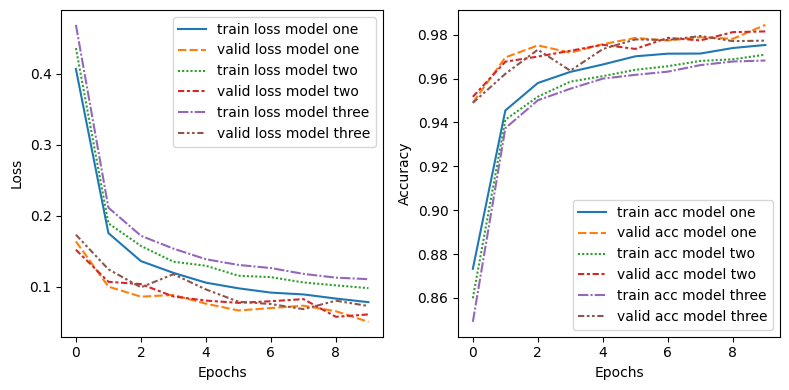

In [24]:
fig, axes = plt.subplots(1,2,figsize = (8,4))
sns.lineplot(data = losses_comparison, ax=axes[0])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
sns.lineplot(data = accuracy_comparison, ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.tight_layout()

**Checking performance on the test dataset**

In [25]:
model_one.load_state_dict(torch.load('tut1-model_one.pt'))
model_two.load_state_dict(torch.load('tut1-model_two.pt'))
model_three.load_state_dict(torch.load('tut1-model_three.pt'))


test_loss_one, test_acc_one = evaluate(model_one, test_iterator, criterion, device)
print(f'Test Loss: {test_loss_one:.3f} | Test Acc: {test_acc_one*100:.2f}%')

test_loss_two, test_acc_two = evaluate(model_two, test_iterator, criterion, device)
print(f'Test Loss: {test_loss_two:.3f} | Test Acc: {test_acc_two*100:.2f}%')

test_loss_three, test_acc_three = evaluate(model_three, test_iterator, criterion, device)
print(f'Test Loss: {test_loss_three:.3f} | Test Acc: {test_acc_three*100:.2f}%')

Test Loss: 0.049 | Test Acc: 98.42%
Test Loss: 0.058 | Test Acc: 98.10%
Test Loss: 0.069 | Test Acc: 97.79%


## Results <br>

We have here the comparison between three neural networks. The simplest one is the one that shows the best results in the end. Now let's try with a convolutional neural network in another notebook.